# Optimizer Testbed

#### This notebook tests optimization algorithms

Tasks
0. MNIST classification (CNN)
0. CIFAR-10 classification (CNN)
0. MNIST GAN?

In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)
colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD']


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


## MNIST classification

Load data

In [2]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Build model:

In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


Train the model, plotting both train and test loss.

In [4]:
# First define a callback to record train and test loss on each minibatch
from keras.callbacks import Callback


class minibatch_History(Callback):
    """Callback that records events into a `History` object.
    
    Predicts over the validation set and each input batch (w/o dropout) 
    after each batch.

    """

    def on_train_begin(self, logs=None):
        self.batch = []
        self.history = {'val_loss':list(),
                        'val_acc':list()}

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.batch.append(batch)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        # add validation loss. Only test on a random subset of minibatch size
        val_loss, val_acc =  self.model.evaluate(self.validation_data[0], 
                                                 self.validation_data[1], verbose=0)   
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_acc)

In [10]:
batch_size = 128
epochs = 1
nb_train = 1000

hist = minibatch_History()

model.fit(x_train[:nb_train], y_train[:nb_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test[:nb_train], y_test[:nb_train]),
          callbacks=[hist])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 1000 samples, validate on 1000 samples
Epoch 1/1


keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (1.696358). Check your callbacks.
  % delta_t_median)
keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (1.745409). Check your callbacks.
  % delta_t_median)
keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (1.794460). Check your callbacks.
  % delta_t_median)
keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (1.822056). Check your callbacks.
  % delta_t_median)
keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (1.706836). Check your callbacks.
  % delta_t_median)


23s - loss: 0.9455 - acc: 0.7210 - val_loss: 0.9387 - val_acc: 0.6650
Test loss: 0.861772220516
Test accuracy: 0.7051


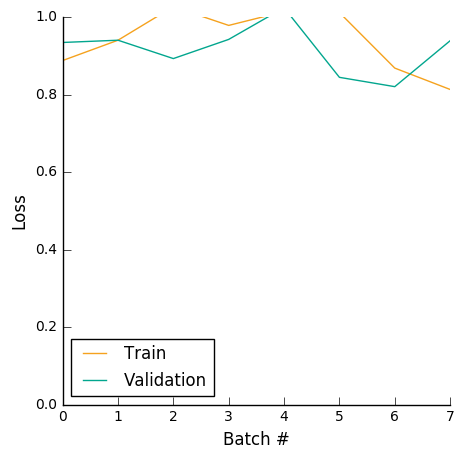

In [12]:
plt.figure(figsize=(5,5))
simpleaxis(plt.gca())

batch_no = hist.history['batch']
plt.plot(batch_no,hist.history['loss'],color=colors[0])
plt.plot(batch_no,hist.history['val_loss'],color=colors[1])
plt.legend(['Train','Validation'],loc=0)
plt.xlabel('Batch #',fontsize='large')
plt.ylabel('Loss',fontsize='large')
plt.ylim((0,1));

Note that the the training loss is higher because it is calculated from the net in training, which has dropout instantiated. TODO change the callback so this prints the actual loss.

## Plot computational graphs

Train a simple 2 layer linear net on a simple problem. Print the computation graph to error check.

We'll be using TensorBoard, since it's awesome. This will print the log file for tensorboard; to see the graph and metrics you'll have to open the log in standalone tensorboard.

Note that this requires us to be using tf as the backend.

In [2]:
# function: z = exp(-x^2 -y^2)

x = np.random.normal(size = (1000,2))
z = np.exp(-x[:,1]**2 -x[:,0]**2)

x_test = np.random.normal(size = (100,2))
z_test = np.exp(-x_test[:,1]**2 -x_test[:,0]**2)


In [3]:
small_model = Sequential()

small_model.add(Dense(2, activation='linear',input_shape=(2,)))
small_model.add(Dense(1, activation='linear'))

opt = keras.optimizers.SGD()
small_model.compile(loss=keras.losses.mean_squared_error,
              optimizer=opt)


In [4]:
# for tensorboard
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

small_model.fit(x,z,
          batch_size=10,
          epochs=10,
          verbose=0,
          validation_data=(x_test, z_test),
          callbacks=[tbCallBack])

In [84]:
# x = np.array([[[1,2], [2,2]], [[3,2], [4,2]]])
# y = np.array([[[5,2], [6,2]], [[7,2], [8,2]]])

x = np.ones((30,2,3))
y = x

print(np.sum(np.multiply(x,y)))

x = K.constant(x)
y = K.constant(y)

K.eval(K.sum(keras.backend.batch_dot(x,y,axes=(0,9)),axis=0))

180.0


array([[ 60.,  60.,  60.],
       [ 60.,  60.,  60.],
       [ 60.,  60.,  60.]], dtype=float32)

In [71]:
x = np.array([[1, 2], [3, 4]])
y = np.array([[5, 6], [7, 8]])

np.sum(np.multiply(x,y))

70